In [1]:
import festim as F
import numpy as np
import sympy as sp
import scipy.constants as const
import os
# TDS simulation of EUROFER for TITANS project.
my_model = F.Simulation()

In [2]:
vertices = np.concatenate(
    [
        np.linspace(0, 10e-6, num=100),
        np.linspace(10e-6, 1e-4, num=100),
        np.linspace(1e-4, 1e-3, num=1000),
    ]
)

In [3]:
# Mesh + Par + Trap + BC
my_model.mesh = F.MeshFromVertices(vertices)

tungsten = F.Material(
    id=1,
    D_0=2.52e-7 / (2) ** 0.5,  # m2/s
    E_D=0.16,  # eV
)

my_model.materials = tungsten

# Parameters
implantation_time = 3600  # s
dwell_time = 1e3  # s
rest_time = 3600 * 12  # s
t_ramp = 980 + 580  # s
start_pdown = implantation_time
N_A_const = const.N_A
w_atom_density = 8.59e28  # atom/m3
implantation_temp = 673  # K
rest_temp = 293  # K
temperature_ramp = 1  # K/s
start_tds = implantation_time + rest_time + dwell_time  # s

# Trap definition
trap_1 = F.Trap(
    k_0=1e13 / 6 / w_atom_density,
    E_k=0.16,
    p_0=1e13,
    E_p=0.51,
    density=7e-4 * w_atom_density,
    materials=tungsten,
)
trap_2 = F.Trap(
    k_0=1e13 / 6 / w_atom_density,
    E_k=0.16,
    p_0=1e13,
    E_p=1.27,
    density=7.49e-7 * w_atom_density,
    materials=tungsten,
)
trap_3 = F.Trap(
    k_0=1e13 / 6 / w_atom_density,
    E_k=0.16,
    p_0=1e13,
    E_p=1.65,
    density=4.517e-6 * w_atom_density,
    materials=tungsten,
)

my_model.traps = [trap_1, trap_2, trap_3]

# Export
import sympy as sp

my_model.boundary_conditions = [
    F.DissociationFlux(
        surfaces=[1],
        Kd_0=1.99e-20 * (1.2e-6 * w_atom_density) ** 2,
        E_Kd=0.27 * 2 + 0.73,
        P=sp.Piecewise(
            (9e4, F.t < start_pdown), (4e4, F.t < start_pdown + dwell_time), (0, True)
        ),
    ),
    F.RecombinationFlux(surfaces=[1], Kr_0=1.99e-20, E_Kr=0.73, order=2),
]

t_ramp2 = 10
my_model.T = F.Temperature(
    value=sp.Piecewise(
        (implantation_temp, F.t < implantation_time),
        (
            implantation_temp
            - ((implantation_temp - rest_temp) / t_ramp2) * (F.t - implantation_time),
            F.t < implantation_time + t_ramp2,
        ),
        (rest_temp, F.t < start_tds),
        (rest_temp + temperature_ramp * (F.t - start_tds), F.t < start_tds + 580),
        (rest_temp + temperature_ramp * (F.t - start_tds) - 580, True),
    )
)


list_of_derived_quantities = [
    F.TotalVolume("retention", volume=1),
    F.TotalVolume("1", volume=1),
    F.TotalVolume("2", volume=1),
    F.TotalVolume("3", volume=1),
    F.HydrogenFlux(surface=1),
    F.AverageVolume("T", volume=1),
]

derived_quantities = F.DerivedQuantities(
    list_of_derived_quantities, filename="tds/derived_quantities.csv"
)


my_model.exports = [derived_quantities]

In [4]:
my_model.dt = F.Stepsize(
    initial_value=1e-6,
    stepsize_change_ratio=1.2,
    dt_min=1e-10,
    t_stop=start_tds - 1000,
    stepsize_stop_max=1,
)

In [5]:
my_model.settings = F.Settings(
    absolute_tolerance=1e11, relative_tolerance=1e-9, final_time=start_tds + t_ramp
)
current_working_directory = os.getcwd()
if current_working_directory.endswith("Festim_models/Jupyter_notebooks"): 
    os.chdir('../../graph_scripts_and_results/TDS_EUROFER')
else:
    os.chdir('graph_scripts_and_results/TDS_EUROFER')   

In [6]:
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        4.9e+04 s    Ellapsed time so far: 288.6 s


In [7]:
t = derived_quantities.t
flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
Temp = derived_quantities.filter(fields="T", volumes=1).data
flux_total = -np.array(flux_left)

Text(0.5, 0, 'Time (s)')

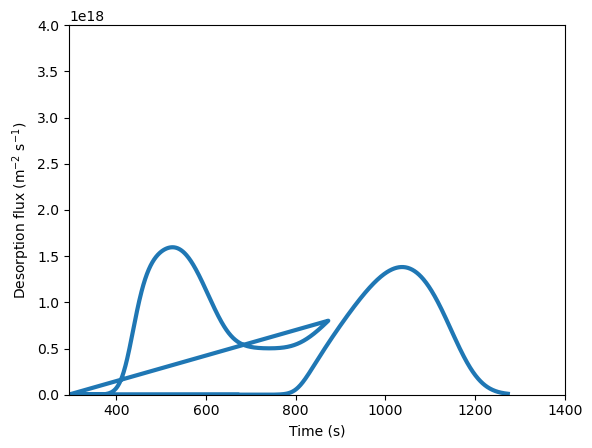

In [8]:
import matplotlib.pyplot as plt

plt.plot(Temp, flux_total, linewidth=3)

plt.xlim(295, 1400)
plt.ylim(0, 4e18)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")